## DQN and Actor Critic Methods 

### Jeffin Biju (EE19B085) and Rajdeep Paul (EE19109)

Contains DQN, one step, n step and full returns Actor Critic Methods for CartPole-v1, Acrobot-v1, MoutainCar-v0.

Code for one step method is different from code for n step and full returns since one step in implemented in an online fashion where updates are made at every time step while n step and full return updates are made at the end of the episode. 

### DQN

#Mountain Car


In [ ]:
import numpy as np


class ReplayBuffer:
    def __init__(self, size, input_shape):
        self.size = size
        self.counter = 0
        self.state_buffer = np.zeros((self.size, input_shape), dtype=np.float32)
        self.action_buffer = np.zeros(self.size, dtype=np.int32)
        self.reward_buffer = np.zeros(self.size, dtype=np.float32)
        self.new_state_buffer = np.zeros((self.size, input_shape), dtype=np.float32)
        self.terminal_buffer = np.zeros(self.size, dtype=np.bool_)

    def store_tuples(self, state, action, reward, new_state, done):
        idx = self.counter % self.size
        self.state_buffer[idx] = state
        self.action_buffer[idx] = action
        self.reward_buffer[idx] = reward
        self.new_state_buffer[idx] = new_state
        self.terminal_buffer[idx] = done
        self.counter += 1

    def sample_buffer(self, batch_size):
        max_buffer = min(self.counter, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch = self.state_buffer[batch]
        action_batch = self.action_buffer[batch]
        reward_batch = self.reward_buffer[batch]
        new_state_batch = self.new_state_buffer[batch]
        done_batch = self.terminal_buffer[batch]

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)

# change path here as per your directory structure
os.chdir('drive/My Drive/CS6700/PA2')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam




def DeepQNetwork(lr, num_actions, input_dims, fc1, fc2):
    q_net = Sequential()
    q_net.add(Dense(fc1, input_dim=input_dims, activation='relu'))
    q_net.add(Dense(fc2, activation='relu'))
    q_net.add(Dense(num_actions, activation=None))
    q_net.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    return q_net


class Agent:
    def __init__(self, lr, discount_factor, num_actions, epsilon, batch_size, input_dims):
        self.action_space = [i for i in range(num_actions)]
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.epsilon_decay = 0.0001
        self.epsilon_final = 0.01
        self.update_rate = 40
        self.step_counter = 0
        self.buffer = ReplayBuffer(300000, input_dims)
        self.q_net = DeepQNetwork(lr, num_actions, input_dims, 256, 256)
        self.q_target_net = DeepQNetwork(lr, num_actions, input_dims, 256, 256)

    def store_tuple(self, state, action, reward, new_state, done):
        self.buffer.store_tuples(state, action, reward, new_state, done)

    def policy(self, observation):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state = np.array([observation])
            actions = self.q_net(state)
            action = tf.math.argmax(actions, axis=1).numpy()[0]

        return action

    def train(self):
        if self.buffer.counter < self.batch_size:
            return
        if self.step_counter % self.update_rate == 0:
            self.q_target_net.set_weights(self.q_net.get_weights())

        state_batch, action_batch, reward_batch, new_state_batch, done_batch = \
            self.buffer.sample_buffer(self.batch_size)

        q_predicted = self.q_net(state_batch)
        q_next = self.q_target_net(new_state_batch)
        q_max_next = tf.math.reduce_max(q_next, axis=1, keepdims=True).numpy()
        q_target = np.copy(q_predicted)

        for idx in range(done_batch.shape[0]):
            target_q_val = reward_batch[idx]
            if not done_batch[idx]:
                target_q_val += self.discount_factor*q_max_next[idx]
            q_target[idx, action_batch[idx]] = target_q_val
        self.q_net.train_on_batch(state_batch, q_target)
        self.epsilon = self.epsilon - self.epsilon_decay if self.epsilon > self.epsilon_final else self.epsilon_final
        self.step_counter += 1

    def train_model(self, env, num_episodes, graph):

        scores, episodes, avg_scores, obj = [], [], [], []
        goal = -110
        f = 0
        txt = open("saved_networks.txt", "w")
        steps_per_epsiode = []

        for i in range(num_episodes):
            done = False
            score = 0.0
            state = env.reset()
            t = 0
            while not done:
                t = t + 1
                action = self.policy(state)
                new_state, reward, done, _ = env.step(action)
                score += reward
                self.store_tuple(state, action, reward, new_state, done)
                state = new_state
                self.train()
            scores.append(score)
            obj.append(goal)
            steps_per_epsiode.append(t)
            episodes.append(i)
            avg_score = np.mean(scores[-100:])
            avg_scores.append(avg_score)
            print("Episode {0}, Score: {1} ({2}), AVG Score: {3}".format(i, score, self.epsilon,
                                                                             avg_score))
            if avg_score >= -110 and score >= -108:
                self.q_net.save(("saved_networks/dqn_model{0}".format(f)))
                self.q_net.save_weights(("saved_networks/dqn_model{0}/net_weights{0}.h5".format(f)))
                txt.write("Save {0} - Episode {1}/{2}, Score: {3} ({4}), AVG Score: {5}\n".format(f, i, num_episodes,score, self.epsilon,avg_score))
                f += 1
                print("Environment Solved in {} episodes".format(i+1))
                break

        #txt.close()
        if graph:
            df = pd.DataFrame({'x': episodes, 'Score': scores, 'Average Score': avg_scores, 'Solved Requirement': obj})

            #plt.plot('x', 'Score', data=df, marker='', color='blue', linewidth=2, label='Score')
            plt.plot('x', 'Average Score', data=df, marker='', color='orange', linewidth=2, linestyle='dashed',
                     label='AverageScore')
            plt.plot('x', 'Solved Requirement', data=df, marker='', color='red', linewidth=2, linestyle='dashed',
                     label='Solved Requirement')
            plt.legend()
            plt.savefig('MC_{}.png'.format(4))
        return steps_per_epsiode


    def test(self, env, num_episodes, file_type, file, graph):
        if file_type == 'tf':
            self.q_net = tf.keras.models.load_model(file)
        elif file_type == 'h5':
            self.train_model(env, 5, False)
            self.q_net.load_weights(file)
        self.epsilon = 0.0
        scores, episodes, avg_scores, obj = [], [], [], []
        goal = -110
        score = 0.0
        for i in range(num_episodes):
            state = env.reset()
            done = False
            episode_score = 0.0
            while not done:
                env.render()
                action = self.policy(state)
                new_state, reward, done, _ = env.step(action)
                episode_score += reward
                state = new_state
            score += episode_score
            scores.append(episode_score)
            obj.append(goal)
            episodes.append(i)
            avg_score = np.mean(scores[-100:])
            avg_scores.append(avg_score)

        if graph:
            df = pd.DataFrame({'x': episodes, 'Score': scores, 'Average Score': avg_scores, 'Solved Requirement': obj})

            #plt.plot('x', 'Score', data=df, marker='', color='blue', linewidth=2, label='Score')
            plt.plot('x', 'Average Score', data=df, linewidth=2,
                     label='AverageScore')
            plt.plot('x', 'Solved Requirement', data=df, marker='', color='red', linewidth=2, linestyle='dashed',
                     label='Solved Requirement')
            plt.legend()
            plt.savefig('MountainCar_Test.png')

        env.close()

Episode 0, Score: -200.0 (1.0), AVG Score: -200.0
Episode 1, Score: -200.0 (0.9855000000000016), AVG Score: -200.0
Episode 2, Score: -200.0 (0.9655000000000038), AVG Score: -200.0
Episode 3, Score: -200.0 (0.945500000000006), AVG Score: -200.0
Episode 4, Score: -200.0 (0.9255000000000082), AVG Score: -200.0
Episode 5, Score: -200.0 (0.9055000000000104), AVG Score: -200.0
Episode 6, Score: -200.0 (0.8855000000000126), AVG Score: -200.0
Episode 7, Score: -200.0 (0.8655000000000148), AVG Score: -200.0
Episode 8, Score: -200.0 (0.845500000000017), AVG Score: -200.0
Episode 9, Score: -200.0 (0.8255000000000192), AVG Score: -200.0
Episode 10, Score: -200.0 (0.8055000000000214), AVG Score: -200.0
Episode 11, Score: -200.0 (0.7855000000000236), AVG Score: -200.0
Episode 12, Score: -200.0 (0.7655000000000258), AVG Score: -200.0
Episode 13, Score: -200.0 (0.745500000000028), AVG Score: -200.0
Episode 14, Score: -200.0 (0.7255000000000302), AVG Score: -200.0
Episode 15, Score: -200.0 (0.705500000

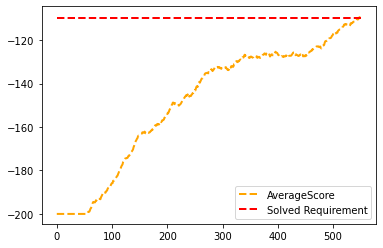

In [ ]:

import gym


env = gym.make("MountainCar-v0")
spec = gym.spec("MountainCar-v0")
train = 1
test = 0
num_episodes = 1500
graph = True

file_type = 'tf'
file = 'saved_networks/dqn_model20'

dqn_agent = Agent(lr=0.004, discount_factor=0.99, num_actions=3, epsilon=1.0, batch_size=256, input_dims=2)

for i in range(10):
  if train and not test:
      steps_per_episode = dqn_agent.train_model(env, num_episodes, graph)
  else:
      dqn_agent.test(env, num_episodes, file_type, file, graph)



In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)

# change path here as per your directory structure
os.chdir('drive/My Drive/CS6700/PA2')

Mounted at /content/drive


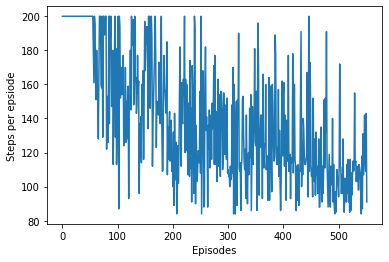

In [ ]:
plt.xlabel('Episodes')
plt.ylabel('Steps per epsiode')
#print(len(steps[0][0]))
plt.plot(np.arange(len(steps_per_episode)), steps_per_episode)
plt.savefig(fname = "config" + "4_mc" + "_steps", format = 'jpeg')
plt.show()

Episode 0, Score: -200.0 (0.9927000000000008), AVG Score: -200.0
Episode 1, Score: -200.0 (0.972700000000003), AVG Score: -200.0
Episode 2, Score: -200.0 (0.9527000000000052), AVG Score: -200.0
Episode 3, Score: -200.0 (0.9327000000000074), AVG Score: -200.0
Episode 4, Score: -200.0 (0.9127000000000096), AVG Score: -200.0
Episode 5, Score: -200.0 (0.8927000000000118), AVG Score: -200.0
Episode 6, Score: -200.0 (0.872700000000014), AVG Score: -200.0
Episode 7, Score: -200.0 (0.8527000000000162), AVG Score: -200.0
Episode 8, Score: -200.0 (0.8327000000000184), AVG Score: -200.0
Episode 9, Score: -200.0 (0.8127000000000206), AVG Score: -200.0
Episode 10, Score: -200.0 (0.7927000000000228), AVG Score: -200.0
Episode 11, Score: -200.0 (0.772700000000025), AVG Score: -200.0
Episode 12, Score: -200.0 (0.7527000000000272), AVG Score: -200.0
Episode 13, Score: -200.0 (0.7327000000000294), AVG Score: -200.0
Episode 14, Score: -200.0 (0.7127000000000316), AVG Score: -200.0
Episode 15, Score: -200

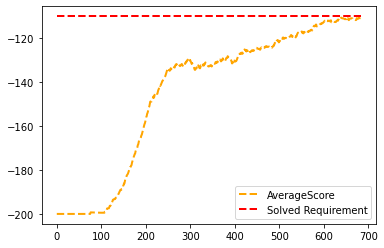

In [ ]:
#from agent import Agent
import gym


env = gym.make("MountainCar-v0")
spec = gym.spec("MountainCar-v0")
train = 1
test = 0
num_episodes = 1500
graph = True

file_type = 'tf'
file = 'saved_networks/dqn_model20'

dqn_agent = Agent(lr=0.001, discount_factor=0.99, num_actions=3, epsilon=1.0, batch_size=128, input_dims=2)

if train and not test:
    steps_per_episode = dqn_agent.train_model(env, num_episodes, graph)
else:
    dqn_agent.test(env, num_episodes, file_type, file, graph)
    

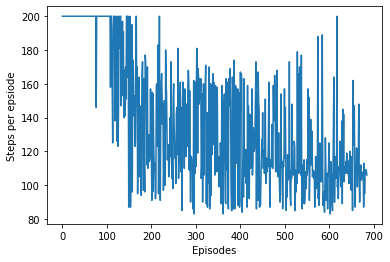

In [ ]:
plt.xlabel('Episodes')
plt.ylabel('Steps per epsiode')
#print(len(steps[0][0]))
plt.plot(np.arange(len(steps_per_episode)), steps_per_episode)
plt.savefig(fname = "config" + "2_mc" + "_steps", format = 'jpeg')
plt.show()

#Acrobot

In [ ]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [ ]:
!pip install tensorflow-gpu

In [ ]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

In [ ]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'CartPole-v0'
'MountainCar-v0'
'''

env = gym.make('CartPole-v0')
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()   
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()  
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, info = env.step(action) 
''' env.step is used to calculate new state and obtain reward based on old state and action taken  ''' 

print(next_state)
print(reward)
print(done)
print(info)
print("----")

In [ ]:
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 64 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()

QNetwork2: Feel free to experiment more
'''

import torch
import torch.nn as nn  
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
BUFFER_SIZE = int(1e5) # ''' replay buffer size '''
BATCH_SIZE = 64         #''' minibatch size '''
GAMMA = 0.99            #''' discount factor '''
LR = 5e-4               #''' learning rate '''
UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''


class QNetwork1(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork1, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
rewards_dqn_epsilon = []
rewards_dqn_softmax = []
class TutorialAgent():

    def __init__(self, state_size, action_size, seed, learning_rate = 5e-4, buffer_size = 1e5, batch_size = 64,  discount = 0.99, update_freq = 20):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.gamma = discount
        self.batch_size = batch_size
        self.update_freq = update_freq


        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr= learning_rate)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size = action_size, buffer_size = buffer_size, batch_size = batch_size, seed = seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)
        
        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''      
        self.t_step = (self.t_step + 1) % self.update_freq
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)
            
        self.optimizer.step()

In [ ]:
from scipy.special import softmax
class TutorialAgent_softmax():

    def __init__(self, state_size, action_size, seed, learning_rate = 5e-4, buffer_size = 1e5, batch_size = 64,  discount = 0.99, update_freq = 20):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.gamma = discount
        self.batch_size = batch_size
        self.update_freq = update_freq

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr= learning_rate)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size = action_size, buffer_size = buffer_size, batch_size = batch_size, seed = seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)
        
        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''      
        self.t_step = (self.t_step + 1) % self.update_freq
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, temp = 1):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' softmax action selection (newly implementing) '''
        #print(action_values.cpu().data.numpy().shape)
        prob = np.nan_to_num(softmax(action_values.cpu().data.numpy()[0]/temp))
        prob /= prob.sum()
        return np.random.choice(self.action_size, p = prob)
        
        


       

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)
            
        self.optimizer.step()

In [ ]:
def dqn_epsilon(env, n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, learning_rate = 5e-4, buffer_size = 1e5, batch_size = 64,  discount = 0.99, update_freq = 20, target = -90):

    state_shape = env.observation_space.shape[0]
    action_shape = env.action_space.n
    agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0, learning_rate = learning_rate, buffer_size = buffer_size, batch_size = batch_size,  discount = discount, update_freq = update_freq)

    scores = []                 
    steps_per_episode = []
    ''' list containing scores from each episode '''

    scores_window_printing = deque(maxlen=10) 
    ''' For printing in the graph '''
    
    scores_window= deque(maxlen=100)  
    ''' last 100 scores for checking if the avg is more than 195 '''

    eps = eps_start                    
    ''' initialize epsilon '''

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
              steps_per_episode.append(t+1)
              break 
        
        if(len(steps_per_episode)!=i_episode):
          steps_per_episode.append(max_t)
        scores_window.append(score)       
        scores_window_printing.append(score)   
        ''' save most recent score '''           

        eps = max(eps_end, eps_decay*eps) 
        ''' decrease epsilon '''

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")  
        
        scores.append(np.mean(scores_window_printing))        
        if i_episode % 100 == 0: 
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>= target:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
           break
    return [np.array(scores),i_episode-100,steps_per_episode]


In [ ]:
def dqn_softmax(env, n_episodes=10000, max_t=1000, temp_start= 10000, temp_end=1, temp_decay=0.995, learning_rate = 5e-4, buffer_size = 1e5, batch_size = 64,  discount = 0.99, update_freq = 20, target = -90):

    state_shape = env.observation_space.shape[0]
    action_shape = env.action_space.n
    agent = TutorialAgent_softmax(state_size=state_shape,action_size = action_shape,seed = 0, learning_rate = learning_rate, buffer_size = buffer_size, batch_size = batch_size,  discount = discount, update_freq = update_freq)
    
    scores = []              
    steps_per_episode = [] 

    ''' list containing scores from each episode '''

    scores_window_printing = deque(maxlen=10) 
    ''' For printing in the graph '''
    
    scores_window= deque(maxlen=100)  
    ''' last 100 scores for checking if the avg is more than 195 '''

    temp = temp_start                    
    ''' initialize epsilon '''

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, temp)
            #print(action)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                steps_per_episode.append(t+1)
                break 
        
        if(len(steps_per_episode) != i_episode):
          steps_per_episode.append(max_t)
        scores_window.append(score)       
        scores_window_printing.append(score)   
        ''' save most recent score '''           

        temp = temp*temp_decay
        ''' decrease epsilon '''

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")  
        
        scores.append(np.mean(scores_window_printing))        
        if i_episode % 100 == 0: 
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>= target:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
           break
    return [np.array(scores),i_episode-100,steps_per_episode]



In [ ]:
def dqn(env, exploration = 'softmax', n_episodes = 10000,  max_t = 1000, hyp_start= 10000, hyp_end=1, hyp_decay=0.995, learning_rate = 5e-4, buffer_size = int(1e5), batch_size = 64,  discount = 0.99, update_freq = 20,target = -90):
  if(exploration == 'epsilon'):
    scores, num_episodes, steps_per_episode = dqn_epsilon(env, n_episodes = n_episodes, max_t = max_t, eps_start= hyp_start, eps_end = hyp_end, eps_decay = hyp_decay, learning_rate= learning_rate, buffer_size = buffer_size, batch_size = batch_size,  discount = discount, update_freq = update_freq)
    return scores, num_episodes, steps_per_episode
  
  else:
    scores, num_episodes,steps_per_episode = dqn_softmax(env, n_episodes = n_episodes, max_t = max_t, temp_start= hyp_start, temp_end = hyp_end, temp_decay = hyp_decay, learning_rate= learning_rate, buffer_size = buffer_size, batch_size = batch_size,  discount = discount, update_freq = update_freq)
    return scores, num_episodes,steps_per_episode






In [ ]:
env2 = gym.make('Acrobot-v1')
episodes_per_run =[]
steps = []
rewards_avg = []
actual_rewards = []


for i1 in range(10):
  steps1 = []
  plt.xlabel('Episodes')
  plt.ylabel('Average_score')
  [scores, num_episodes, steps_per_episode] = dqn(env2, exploration = 'epsilon',learning_rate = 0.001, hyp_start = 1, hyp_decay = 0.995,hyp_end = 0.001,update_freq = 100, buffer_size = int(2e5))
  episodes_per_run.append(num_episodes)
  actual_rewards.append(scores)
  steps.append(steps_per_episode)
  y_axis = []
  n_ep = len(scores)
  for i in range(len(scores)):
    idx = min(99,i)
    y_axis.append(np.mean(scores[i-idx:i+1]))
    
  plt.plot(np.arange(len(y_axis)) ,y_axis)
  rewards_avg.append(y_axis)

  plt.savefig(fname = "acrobot1 " + "run " + str(i1),format = 'jpeg')
  #steps.append(steps1)
  plt.show()

In [ ]:
np.save('acrobot1_arr', actual_rewards)

In [ ]:
y_axis_f = []
mn = np.min(episodes_per_run)
for i in range(mn):
  total = 0
  for j in rewards_avg:
    total += j[i]
  y_axis_f.append(total)

plt.plot(np.arange(mn),y_axis_f)
plt.xlabel('Rewards')
plt.ylabel('Episodes')
plt.savefig(fname = 'acrobot_ avg 1', format = 'jpeg')
plt.show()

print('Avg number of episodes req = {}'.format(np.mean(episodes_per_run)))

In [ ]:
arr = np.load('acrobot1_arr.npy',allow_pickle=True)
print('for cartpole_1')
cnt = 0
for rewards in arr:
  cnt = cnt + 1
  print('Taking running avg of 100')
  y_axis = []
  for i in range(len(rewards)):
    idx = max(0,i-99)
    y_axis.append(np.mean(rewards[idx:i+1]))

  plt.ylabel('rewards avg 100')
  plt.xlabel('episodes')
  plt.title('acrobot_1 run {} 100 avg'.format(cnt))
  plt.plot(np.arange(len(rewards)),y_axis)
  plt.savefig(fname = 'acrobot_1 run {} 100 avg'.format(cnt) , format = 'jpeg')
  plt.show()

  print('Taking running avg of 10')
  y_axis = []
  for i in range(len(rewards)):
    idx = max(0,i-9)
    y_axis.append(np.mean(rewards[idx:i+1]))

  plt.ylabel('rewards avg 10')
  plt.xlabel('episodes')
  plt.title('acrobot_1 run {} 10 avg'.format(cnt))
  plt.plot(np.arange(len(rewards)),y_axis)
  plt.savefig(fname = 'acrobot_1 run {} 10 avg'.format(cnt) , format = 'jpeg')
  plt.show()

  print('Taking running avg of 1')
  y_axis = []
  for i in range(len(rewards)):
    idx = max(0,i)
    y_axis.append(np.mean(rewards[idx:i+1]))

  plt.ylabel('rewards avg 10')
  plt.xlabel('episodes')
  plt.title('acrobot_1 run {} 1 avg'.format(cnt))
  plt.plot(np.arange(len(rewards)),y_axis)
  plt.savefig(fname = 'acrobot_1 run {} 1 avg'.format(cnt) , format = 'jpeg')
  plt.show()


In [ ]:
env2 = gym.make('Acrobot-v1')
episodes_per_run =[]
steps = []
rewards_avg = []
actual_rewards = []


for i1 in range(10):
  steps1 = []
  plt.xlabel('Episodes')
  plt.ylabel('Average_score')
  [scores, num_episodes, steps_per_episode] = dqn(env2, exploration = 'epsilon',learning_rate = 0.001, hyp_start = 1, hyp_decay = 0.995,hyp_end = 0.001,update_freq = 50, buffer_size = int(2e5),batch_size = 128)
  episodes_per_run.append(num_episodes)
  actual_rewards.append(scores)
  steps.append(steps_per_episode)
  y_axis = []
  n_ep = len(scores)
  for i in range(len(scores)):
    idx = min(99,i)
    y_axis.append(np.mean(scores[i-idx:i+1]))
    
  plt.plot(np.arange(len(y_axis)) ,y_axis)
  rewards_avg.append(y_axis)

  plt.savefig(fname = "acrobot2 " + "run " + str(i1),format = 'jpeg')
  #steps.append(steps1)
  plt.show()

In [ ]:
y_axis_f = []
mn = np.min(episodes_per_run)
for i in range(mn):
  total = 0
  for j in rewards_avg:
    total += j[i]
  y_axis_f.append(total)

plt.plot(np.arange(mn),y_axis_f)
plt.xlabel('Rewards')
plt.ylabel('Episodes')
plt.savefig(fname = 'acrobot_ avg 2', format = 'jpeg')
plt.show()

print('Avg number of episodes req = {}'.format(np.mean(episodes_per_run)))

In [ ]:
np.save('acrobot2_arr', actual_rewards)

In [ ]:
arr = np.load('acrobot2_arr.npy',allow_pickle=True)
print('for acrobot_2')
cnt = 0
for rewards in arr:
  cnt = cnt + 1
  print('Taking running avg of 100')
  y_axis = []
  for i in range(len(rewards)):
    idx = max(0,i-99)
    y_axis.append(np.mean(rewards[idx:i+1]))

  plt.ylabel('rewards avg 100')
  plt.xlabel('episodes')
  plt.title('acrobot_2 run {} 100 avg'.format(cnt))
  plt.plot(np.arange(len(rewards)),y_axis)
  plt.savefig(fname = 'acrobot_2 run {} 100 avg'.format(cnt) , format = 'jpeg')
  plt.show()

  print('Taking running avg of 10')
  y_axis = []
  for i in range(len(rewards)):
    idx = max(0,i-9)
    y_axis.append(np.mean(rewards[idx:i+1]))

  plt.ylabel('rewards avg 10')
  plt.xlabel('episodes')
  plt.title('acrobot_2 run {} 10 avg'.format(cnt))
  plt.plot(np.arange(len(rewards)),y_axis)
  plt.savefig(fname = 'acrobot_2 run {} 10 avg'.format(cnt) , format = 'jpeg')
  plt.show()

  print('Taking running avg of 1')
  y_axis = []
  for i in range(len(rewards)):
    idx = max(0,i)
    y_axis.append(np.mean(rewards[idx:i+1]))

  plt.ylabel('rewards avg 10')
  plt.xlabel('episodes')
  plt.title('acrobot_2 run {} 1 avg'.format(cnt))
  plt.plot(np.arange(len(rewards)),y_axis)
  plt.savefig(fname = 'acrobot_2 run {} 1 avg'.format(cnt) , format = 'jpeg')
  plt.show()


In [ ]:

env2 = gym.make('Acrobot-v1')
episodes_per_run =[]
steps = []
rewards_avg = []
actual_rewards = []


for i1 in range(10):
  steps1 = []
  plt.xlabel('Episodes')
  plt.ylabel('Average_score')
  [scores, num_episodes, steps_per_episode] = dqn(env2, exploration = 'epsilon',learning_rate = 0.001, hyp_start = 1, hyp_decay = 0.995,hyp_end = 0.001,update_freq = 100, buffer_size = int(2e5),batch_size = 128)
  actual_rewards.append(scores)
  steps.append(steps_per_episode)
  y_axis = []
  n_ep = len(scores)
  for i in range(len(scores)):
    idx = min(99,i)
    y_axis.append(np.mean(scores[i-idx:i+1]))
    
  plt.plot(np.arange(len(y_axis)) ,y_axis)
  rewards_avg.append(y_axis)

  plt.savefig(fname = "acrobot3 " + "run " + str(i1),format = 'jpeg')
  #steps.append(steps1)
  plt.show()

In [ ]:
y_axis_f = []
#mn = np.min(episodes_per_run[0:-2])
mn = 443
for i in range(mn):
  total = 0
  for j in rewards_avg:
    total += j[i]
  y_axis_f.append(total)

plt.plot(np.arange(mn),y_axis_f)
plt.xlabel('Rewards')
plt.ylabel('Episodes')
plt.savefig(fname = 'acrobot_ avg 3', format = 'jpeg')
plt.show()

print('Avg number of episodes req = {}'.format(446))

In [ ]:
np.save('acrobot3_arr', actual_rewards)

arr = np.load('acrobot3_arr.npy',allow_pickle=True)
print('for acrobot_3')
cnt = 0
for rewards in arr:
  cnt = cnt + 1
  print('Taking running avg of 100')
  y_axis = []
  for i in range(len(rewards)):
    idx = max(0,i-99)
    y_axis.append(np.mean(rewards[idx:i+1]))

  plt.ylabel('rewards avg 100')
  plt.xlabel('episodes')
  plt.title('acrobot_3 run {} 100 avg'.format(cnt))
  plt.plot(np.arange(len(rewards)),y_axis)
  plt.savefig(fname = 'acrobot_3 run {} 100 avg'.format(cnt) , format = 'jpeg')
  plt.show()

  print('Taking running avg of 10')
  y_axis = []
  for i in range(len(rewards)):
    idx = max(0,i-9)
    y_axis.append(np.mean(rewards[idx:i+1]))

  plt.ylabel('rewards avg 10')
  plt.xlabel('episodes')
  plt.title('acrobot_3 run {} 10 avg'.format(cnt))
  plt.plot(np.arange(len(rewards)),y_axis)
  plt.savefig(fname = 'acrobot_3 run {} 10 avg'.format(cnt) , format = 'jpeg')
  plt.show()

  print('Taking running avg of 1')
  y_axis = []
  for i in range(len(rewards)):
    idx = max(0,i)
    y_axis.append(np.mean(rewards[idx:i+1]))

  plt.ylabel('rewards avg 10')
  plt.xlabel('episodes')
  plt.title('acrobot_3 run {} 1 avg'.format(cnt))
  plt.plot(np.arange(len(rewards)),y_axis)
  plt.savefig(fname = 'acrobot_3 run {} 1 avg'.format(cnt) , format = 'jpeg')
  plt.show()

In [ ]:



env2 = gym.make('Acrobot-v1')
episodes_per_run =[]
steps = []
rewards_avg = []
actual_rewards = []


for i1 in range(10):
  steps1 = []
  plt.xlabel('Episodes')
  plt.ylabel('Average_score')
  [scores, num_episodes, steps_per_episode] = dqn(env2, exploration = 'epsilon',learning_rate = 0.003, hyp_start = 1, hyp_decay = 0.995,hyp_end = 0.001,update_freq = 75, buffer_size = int(2e5),batch_size = 128)
  episodes_per_run.append(num_episodes)
  actual_rewards.append(scores)
  steps.append(steps_per_episode)
  y_axis = []
  n_ep = len(scores)
  for i in range(len(scores)):
    idx = min(99,i)
    y_axis.append(np.mean(scores[i-idx:i+1]))
    
  plt.plot(np.arange(len(y_axis)) ,y_axis)
  rewards_avg.append(y_axis)

  plt.savefig(fname = "acrobot4 " + "run " + str(i1),format = 'jpeg')
  #steps.append(steps1)
  plt.show()

In [ ]:
y_axis_f = []
mn = np.min(episodes_per_run)
for i in range(mn):
  total = 0
  for j in rewards_avg:
    total += j[i]
  y_axis_f.append(total)

plt.plot(np.arange(mn),y_axis_f)
plt.xlabel('Rewards')
plt.ylabel('Episodes')
plt.savefig(fname = 'acrobot_ avg 4', format = 'jpeg')
plt.show()

print('Avg number of episodes req = {}'.format(np.mean(episodes_per_run)))

In [ ]:
np.save('acrobot4_arr', actual_rewards)

arr = np.load('acrobot4_arr.npy',allow_pickle=True)
print('for acrobot_4')
cnt = 0
for rewards in arr:
  cnt = cnt + 1
  print('Taking running avg of 100')
  y_axis = []
  for i in range(len(rewards)):
    idx = max(0,i-99)
    y_axis.append(np.mean(rewards[idx:i+1]))

  plt.ylabel('rewards avg 100')
  plt.xlabel('episodes')
  plt.title('acrobot_4 run {} 100 avg'.format(cnt))
  plt.plot(np.arange(len(rewards)),y_axis)
  plt.savefig(fname = 'acrobot_4 run {} 100 avg'.format(cnt) , format = 'jpeg')
  plt.show()

  print('Taking running avg of 10')
  y_axis = []
  for i in range(len(rewards)):
    idx = max(0,i-9)
    y_axis.append(np.mean(rewards[idx:i+1]))

  plt.ylabel('rewards avg 10')
  plt.xlabel('episodes')
  plt.title('acrobot_4 run {} 10 avg'.format(cnt))
  plt.plot(np.arange(len(rewards)),y_axis)
  plt.savefig(fname = 'acrobot_4 run {} 10 avg'.format(cnt) , format = 'jpeg')
  plt.show()

  print('Taking running avg of 1')
  y_axis = []
  for i in range(len(rewards)):
    idx = max(0,i)
    y_axis.append(np.mean(rewards[idx:i+1]))

  plt.ylabel('rewards avg 10')
  plt.xlabel('episodes')
  plt.title('acrobot_4 run {} 1 avg'.format(cnt))
  plt.plot(np.arange(len(rewards)),y_axis)
  plt.savefig(fname = 'acrobot_4 run {} 1 avg'.format(cnt) , format = 'jpeg')
  plt.show()

In [ ]:
env2 = gym.make('Acrobot-v1')
episodes_per_run =[]
steps = []
rewards_avg = []
actual_rewards = []

for i1 in range(10):
  steps1 = []
  plt.xlabel('Episodes')
  plt.ylabel('Average_score')
  [scores, num_episodes, steps_per_episode] = dqn(env2, exploration = 'epsilon',learning_rate = 0.005, hyp_start = 1, hyp_decay = 0.995,hyp_end = 0.001,update_freq = 75, buffer_size = int(2e5),batch_size = 128)
  episodes_per_run.append(num_episodes)
  actual_rewards.append(scores)
  steps.append(steps_per_episode)
  y_axis = []
  n_ep = len(scores)
  for i in range(len(scores)):
    idx = min(99,i)
    y_axis.append(np.mean(scores[i-idx:i+1]))
    
  plt.plot(np.arange(len(y_axis)) ,y_axis)
  rewards_avg.append(y_axis)

  plt.savefig(fname = "acrobot5 " + "run " + str(i1),format = 'jpeg')
  #steps.append(steps1)
  plt.show()

In [ ]:
y_axis_f = []
mn = np.min(episodes_per_run)
for i in range(mn):
  total = 0
  for j in rewards_avg:
    total += j[i]
  y_axis_f.append(total)

plt.plot(np.arange(mn),y_axis_f)
plt.xlabel('Rewards')
plt.ylabel('Episodes')
plt.savefig(fname = 'acrobot_ avg 5', format = 'jpeg')
plt.show()

print('Avg number of episodes req = {}'.format(np.mean(episodes_per_run)))

In [ ]:
np.save('acrobot5_arr', actual_rewards)

arr = np.load('acrobot5_arr.npy',allow_pickle=True)
print('for acrobot_5')
cnt = 0
for rewards in arr:
  cnt = cnt + 1
  print('Taking running avg of 100')
  y_axis = []
  for i in range(len(rewards)):
    idx = max(0,i-99)
    y_axis.append(np.mean(rewards[idx:i+1]))

  plt.ylabel('rewards avg 100')
  plt.xlabel('episodes')
  plt.title('acrobot_5 run {} 100 avg'.format(cnt))
  plt.plot(np.arange(len(rewards)),y_axis)
  plt.savefig(fname = 'acrobot_5 run {} 100 avg'.format(cnt) , format = 'jpeg')
  plt.show()

  print('Taking running avg of 10')
  y_axis = []
  for i in range(len(rewards)):
    idx = max(0,i-9)
    y_axis.append(np.mean(rewards[idx:i+1]))

  plt.ylabel('rewards avg 10')
  plt.xlabel('episodes')
  plt.title('acrobot_5 run {} 10 avg'.format(cnt))
  plt.plot(np.arange(len(rewards)),y_axis)
  plt.savefig(fname = 'acrobot_5 run {} 10 avg'.format(cnt) , format = 'jpeg')
  plt.show()

  print('Taking running avg of 1')
  y_axis = []
  for i in range(len(rewards)):
    idx = max(0,i)
    y_axis.append(np.mean(rewards[idx:i+1]))

  plt.ylabel('rewards avg 10')
  plt.xlabel('episodes')
  plt.title('acrobot_5 run {} 1 avg'.format(cnt))
  plt.plot(np.arange(len(rewards)),y_axis)
  plt.savefig(fname = 'acrobot_5 run {} 1 avg'.format(cnt) , format = 'jpeg')
  plt.show()

#CartPole


In [ ]:
env2 = gym.make('CartPole-v1')
episodes_per_run =[]
steps = []
rewards_avg = []
actual_rewards = []


for i1 in range(10):
  steps1 = []
  plt.xlabel('Episodes')
  plt.ylabel('Average_score')
  [scores, num_episodes, steps_per_episode] = dqn(env2 , learning_rate = 0.0005,update_freq = 25, buffer_size = int(1e5),batch_size = 64)
  episodes_per_run.append(num_episodes)
  actual_rewards.append(scores)
  steps.append(steps_per_episode)
  y_axis = []
  n_ep = len(scores)
  for i in range(len(scores)):
    idx = min(99,i)
    y_axis.append(np.mean(scores[i-idx:i+1]))
    
  plt.plot(np.arange(len(y_axis)) ,y_axis)
  rewards_avg.append(y_axis)

  plt.savefig(fname = "Cartpole config" + "3" + str(i1),format = 'jpeg')
  #steps.append(steps1)
  plt.show()

In [ ]:
y_axis_f = []
mn = np.min(episodes_per_run)
for i in range(mn):
  total = 0
  for j in rewards_avg:
    total += j[i]
  y_axis_f.append(total)

plt.plot(np.arange(mn),y_axis_f)
plt.xlabel('Rewards')
plt.ylabel('Episodes')
plt.savefig(fname = 'acrofinal 4', format = 'jpeg')
plt.show()

print('Avg number of episodes req = {}'.format(np.mean(episodes_per_run)))

In [ ]:
#save the array of rewards
np.save('cartpole1_arr', actual_rewards)

In [ ]:
arr = np.load('cartpole1_arr.npy',allow_pickle=True)
print('for cartpole_1')
cnt = 0
for rewards in arr:
  cnt = cnt + 1
  print('Taking running avg of 100')
  y_axis = []
  for i in range(len(rewards)):
    idx = max(0,i-99)
    y_axis.append(np.mean(rewards[idx:i+1]))

  plt.ylabel('rewards avg 100')
  plt.xlabel('episodes')
  plt.title('cartpole_1 run {} 100 avg'.format(cnt))
  plt.plot(np.arange(len(rewards)),y_axis)
  plt.savefig(fname = 'cartpole_1 run {} 100 avg'.format(cnt) , format = 'jpeg')
  plt.show()

  print('Taking running avg of 10')
  y_axis = []
  for i in range(len(rewards)):
    idx = max(0,i-9)
    y_axis.append(np.mean(rewards[idx:i+1]))

  plt.ylabel('rewards avg 10')
  plt.xlabel('episodes')
  plt.title('cartpole_1 run {} 10 avg'.format(cnt))
  plt.plot(np.arange(len(rewards)),y_axis)
  plt.savefig(fname = 'cartpole_1 run {} 10 avg'.format(cnt) , format = 'jpeg')
  plt.show()

  print('Taking running avg of 1')
  y_axis = []
  for i in range(len(rewards)):
    idx = max(0,i)
    y_axis.append(np.mean(rewards[idx:i+1]))

  plt.ylabel('rewards avg 10')
  plt.xlabel('episodes')
  plt.title('cartpole_1 run {} 1 avg'.format(cnt))
  plt.plot(np.arange(len(rewards)),y_axis)
  plt.savefig(fname = 'cartpole_1 run {} 1 avg'.format(cnt) , format = 'jpeg')
  plt.show()


#### Actor Critic Methods

In [ ]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym
!pip install pyglet
# Install additional packages for visualization
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [ ]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp
import collections
import gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple

In [ ]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()


In [ ]:
class ActorCriticModel(tf.keras.Model):
    """
    Defining policy and value networkss
    """
    def __init__(self, action_size, n_hidden1=128, n_hidden2=256, temp=1.0):
        super(ActorCriticModel, self).__init__()

        #Hidden Layer 1
        self.fc1 = tf.keras.layers.Dense(n_hidden1, activation='relu')
        #Hidden Layer 2
        self.fc2 = tf.keras.layers.Dense(n_hidden2, activation='relu')
        
        #Output Layer for policy
        self.pi_out = tf.keras.layers.Dense(action_size, activation='softmax')
        #Output Layer for state-value
        self.v_out = tf.keras.layers.Dense(1)
        self.temp = temp

    def call(self, state):
        """
        Computes policy distribution and state-value for a given state
        """
        layer1 = self.fc1(state)
        layer2 = self.fc2(layer1)

        pi = self.pi_out(layer2)
        v = self.v_out(layer2)
        return pi/self.temp, v

In [ ]:
class Agent:
    """
    Agent class
    """
    def __init__(self, action_size, lr=0.001, gamma=0.99, n_hidden1=128, n_hidden2=256, temp=1, seed = 85):
        self.gamma = gamma
        self.ac_model = ActorCriticModel(action_size, n_hidden1, n_hidden2, temp=temp)
        self.ac_model.compile(tf.keras.optimizers.Adam(learning_rate=lr))
        np.random.seed(seed)
    
    def sample_action(self, state):
        """
        Given a state, compute the policy distribution over all actions and sample one action
        """
        pi,_ = self.ac_model(state)

        action_probabilities = tfp.distributions.Categorical(probs=pi)
        sample = action_probabilities.sample()

        return int(sample.numpy()[0])

    def actor_loss(self, action, pi, delta):
        """
        Compute Actor Loss
        """
        return -tf.math.log(pi[0,action]) * delta

    def critic_loss(self,delta):
        """
        Critic loss aims to minimize TD error
        """
        return delta**2

    
    def learn(self, state, action, reward, next_state, done):
        """
        For a given transition (s,a,s',r) update the paramters by computing the
        gradient of the total loss
        """
        with tf.GradientTape(persistent=True) as tape:
            pi, V_s = self.ac_model(state)
            _, V_s_next = self.ac_model(next_state)
            
            V_s = tf.squeeze(V_s)
            V_s_next = tf.squeeze(V_s_next)
            

            #### TO DO: Write the equation for delta (TD error)
            ## Write code below
            delta = reward + self.gamma*V_s_next - V_s

            loss_a = self.actor_loss(action, pi, delta)
            loss_c =self.critic_loss(delta)
            loss_total = loss_a + loss_c

        gradient = tape.gradient(loss_total, self.ac_model.trainable_variables)
        self.ac_model.optimizer.apply_gradients(zip(gradient, self.ac_model.trainable_variables))

In [ ]:
def save_plots_and_arrays1(environment, nstep, all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, config=1, num_exp=10):
    min_episodes = min(num_episodes_taken)
    avg1 = np.zeros(shape=(num_exp, min_episodes))
    avg2 = np.zeros(shape=(num_exp, min_episodes))
    avg3 = np.zeros(shape=(num_exp, min_episodes))
    for exp in range(num_exp):
        avg_rewards_1 = np.array(all_avg_rewards_1[exp])
        avg_rewards_2 = np.array(all_avg_rewards_1[exp])
        avg_rewards_3 = np.array(all_avg_rewards_1[exp])
        avg1[exp] = avg_rewards_1[:min_episodes]
        avg2[exp] = avg_rewards_2[:min_episodes]
        avg3[exp] = avg_rewards_3[:min_episodes]
        episodes = avg_rewards_1.shape[0]
        np.save('{}_{}_{}_{}_1'.format(environment, nstep, config, exp), avg_rewards_1)
        np.save('{}_{}_{}_{}_2'.format(environment, nstep, config, exp), avg_rewards_2)
        np.save('{}_{}_{}_{}_3'.format(environment, nstep, config, exp), avg_rewards_3)
        print(np.std(avg_rewards_1), np.std(avg_rewards_2), np.std(avg_rewards_3))
        plt.figure(figsize = (6, 4))
        plt.plot(np.arange(0, episodes), avg_rewards_1)
        plt.xlabel('Episodes')
        plt.ylabel('Average Rewards')
        plt.savefig('{}_{}_{}_{}_1'.format(environment, nstep, config, exp))
        plt.figure(figsize = (6, 4))
        plt.plot(np.arange(0, episodes), avg_rewards_2)
        plt.xlabel('Episodes')
        plt.ylabel('Average Rewards')
        plt.savefig('{}_{}_{}_{}_2'.format(environment, nstep, config, exp))
        plt.figure(figsize = (6, 4))
        plt.plot(np.arange(0, episodes), avg_rewards_3)
        plt.xlabel('Episodes')
        plt.ylabel('Average Rewards')
        plt.savefig('{}_{}_{}_{}_3'.format(environment, nstep, config, exp))


In [ ]:
%%time
def Actor_Critic_run_1(env, num_experiments=10, max_episodes = 5000, max_steps_per_episode = 1000, temp=0.1, decay=0.99, nstep=1000, gamma=0.99, n_hidden1=128, n_hidden2=256, reward_threshold=-100, lr=0.01):

    all_avg_rewards_1 = []
    all_avg_rewards_2 = []
    all_avg_rewards_3 = []
    num_episodes_taken = []
    agents = []

    for i in range(num_experiments):
        #Initializing Agent
        agent = Agent(lr=lr, action_size=env.action_space.n, gamma=gamma, n_hidden1=128, n_hidden2=256, temp=temp)
        #Number of episodes
        episodes = max_episodes
        tf.compat.v1.reset_default_graph()
        episodes_reward: collections.deque = collections.deque(maxlen=100)
        avg_reward: collections.deque = collections.deque(maxlen=10)
        reward_list = []
        average_reward_list = []
        begin_time = datetime.datetime.now()
        avg_rewards_1 = []
        avg_rewards_2 = []
        avg_rewards_3 = []
        f = tf.function(agent.learn)
        num = 0
        for ep in range(1, episodes + 1):
            state = env.reset().reshape(1,-1)
            done = False
            ep_rew = 0
            while not done:
                action = agent.sample_action(state) ##Sample Action
                next_state, reward, done, info = env.step(action) ##Take action
                next_state = next_state.reshape(1,-1)
                ep_rew += reward  ##Updating episode reward
                f(state, action, reward, next_state, done) ##Update Parameters
                state = next_state ##Updating State
            avg_reward.append(ep_rew)
            episodes_reward.append(ep_rew)
            reward_list.append(ep_rew)
            avg_rewards_1.append(ep_rew)
            avg_rewards_2.append(statistics.mean(avg_reward))
            avg_rewards_3.append(statistics.mean(episodes_reward))
            num += 1
            if ep % 10 == 0:
                avg_rew = np.mean(reward_list[-10:])
                print('Episode ', ep, 'Reward %f' % ep_rew, 'Average Reward %f' % np.mean(reward_list[-100:]))

            if ep % 100:
                avg_100 =  np.mean(reward_list[-100:])
                if avg_100 > reward_threshold:
                    print('Stopped at Episode ',ep)
                    break
        all_avg_rewards_1.append(avg_rewards_1)
        all_avg_rewards_2.append(avg_rewards_2)
        all_avg_rewards_3.append(avg_rewards_3)
        agents.append(agent)
        num_episodes_taken.append(num)
    return all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, agents


### One step

### Acrobot

In [ ]:
environment = 'Acrobot-v1'
env = gym.make('Acrobot-v1')
num_experiments = 10
max_episodes = 5000
reward_threshold = -100
nstep = 1
temp = 1
gamma = 0.99
n_hidden1 = 128
n_hidden2 = 256
lr = 0.01
all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, agents = Actor_Critic_run_1(env=env, num_experiments=num_experiments, max_episodes = max_episodes, max_steps_per_episode = 10, temp=temp, decay=0.99, nstep=nstep, gamma=gamma, n_hidden1=n_hidden1, n_hidden2=n_hidden2, reward_threshold=reward_threshold, lr=lr)
save_plots_and_arrays1(environment, nstep, all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, config=1, num_exp=num_experiments)

### Cartpole

In [ ]:
environment = 'CartPole-v1'
env = gym.make('CartPole-v1')
num_experiments = 10
max_episodes = 5000
reward_threshold = 230
nstep = 1
temp = 1
gamma = 0.99
n_hidden1 = 128
n_hidden2 = 256
lr = 0.01
all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, agents = Actor_Critic_run_1(env=env, num_experiments=num_experiments, max_episodes = max_episodes, max_steps_per_episode = 10, temp=temp, decay=0.99, nstep=nstep, gamma=gamma, n_hidden1=n_hidden1, n_hidden2=n_hidden2, reward_threshold=reward_threshold, lr=lr)
save_plots_and_arrays1(environment, nstep, all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, config=1, num_exp=num_experiments)

### Mountain Car

In [ ]:
environment = 'MountainCar-v0'
env = gym.make('MountainCar-v0')
num_experiments = 10
max_episodes = 5000
reward_threshold = -110
nstep = 1
temp = 1
gamma = 0.99
n_hidden1 = 128
n_hidden2 = 256
lr = 0.01
all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, agents = Actor_Critic_run_1(env=env, num_experiments=num_experiments, max_episodes = max_episodes, max_steps_per_episode = 10, temp=temp, decay=0.99, nstep=nstep, gamma=gamma, n_hidden1=n_hidden1, n_hidden2=n_hidden2, reward_threshold=reward_threshold, lr=lr)
save_plots_and_arrays1(environment, nstep, all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, config=1, num_exp=num_experiments)

## n step and Full returns.
set nstep = 1000 for full returns

In [ ]:
class ActorCritic(tf.keras.Model):
  """ Separate Actor-critic network."""

  def __init__(
      self, 
      num_actions: int,
      actor_units1: int, 
      actor_units2: int, 
      critic_units1: int, 
      critic_units2: int):
    """Initialize."""
    super().__init__()
    self.actor_layer1 = layers.Dense(actor_units1, activation="relu")
    self.actor_layer2 = layers.Dense(actor_units2, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic_layer1 = layers.Dense(critic_units1, activation="relu")
    self.critic_layer2 = layers.Dense(critic_units2, activation="relu")
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.actor_layer1(inputs)
    x = self.actor_layer2(x)
    y = self.critic_layer1(inputs)
    y = self.critic_layer2(y)
    return self.actor(x), self.critic(y)

In [ ]:
# Wrap OpenAI Gym's `env.step` call as an operation in a TensorFlow function.
# This would allow it to be included in a callable TensorFlow graph.

def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  """Returns state, reward and done flag given an action."""

  state, reward, done, _ = env.step(action)
  return (state.astype(np.float32), 
          np.array(reward, np.int32), 
          np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
  return tf.numpy_function(env_step, [action], 
                           [tf.float32, tf.int32, tf.int32])

In [ ]:
def run_episode(
    initial_state: tf.Tensor,  
    model: tf.keras.Model, 
    max_steps: int,
    temp: int) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor, int]:
  """Runs a single episode to collect training data."""

  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
  t = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
  initial_state_shape = initial_state.shape
  state = initial_state
  steps = 0

  for t in tf.range(max_steps):
    # Convert state into a batched tensor (batch size = 1)
    state = tf.expand_dims(state, 0)

    # Run the model and to get action probabilities and critic value
    action_logits_t, value = model(state)
    action_logits_t = action_logits_t/temp
    # Sample next action from the action probability distribution
    action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action_probs_t = tf.nn.softmax(action_logits_t)

    # Store critic values
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])

    # Apply action to the environment to get next state and reward
    state, reward, done = tf_env_step(action)
    state.set_shape(initial_state_shape)

    # Store reward
    rewards = rewards.write(t, reward)
    steps = steps + 1

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()

  return action_probs, values, rewards, steps

In [ ]:
# Finds n step return for any time step. Set n=1000 for full return.

def get_expected_return(
    rewards: tf.Tensor,
    values: tf.Tensor, 
    gamma: float,
    nstep: int,
    standardize: bool = True) -> tf.Tensor:
  """Compute n step return per timestep."""


  a = pow(gamma, nstep)
  b = pow(gamma, nstep-1)
  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)
  rewards = tf.cast(rewards, dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  if nstep == 1000:   
      nstep = n
  for i in tf.range(n-1, -1, -1):
    reward = rewards[i]
    if i+nstep >= n:
        discounted_sum = reward + gamma * discounted_sum
    else:
        discounted_sum = reward + gamma * discounted_sum + a*values[i+nstep]
    
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
    if i+nstep < n:
        discounted_sum -= a*values[i+nstep]
    if i+nstep-1 < n:
        discounted_sum -= b*rewards[i+nstep-1]
    discounted_sum.set_shape(discounted_sum_shape)

  returns = returns.stack()
  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) / 
               (tf.math.reduce_std(returns) + eps))
  
  return returns

In [ ]:
mse_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,  
    values: tf.Tensor,  
    returns: tf.Tensor) -> tf.Tensor:
  """Computes the combined actor-critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = mse_loss(values, returns)

  return actor_loss + critic_loss

In [ ]:
def train_step(
    initial_state: tf.Tensor, 
    model: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Optimizer, 
    gamma: float, 
    max_steps_per_episode: int,
    nstep: int,
    temp: int) -> Tuple[tf.Tensor, int]:
  """Runs a model training step."""

  with tf.GradientTape() as tape:
    # Run the model for one episode to collect training data
    action_probs, values, rewards, steps = run_episode(
        initial_state, model, max_steps_per_episode, temp) 

    # Calculate expected returns
    returns = get_expected_return(rewards, values, gamma, nstep)
    # return rewards, values, returns
    #returns = get_expected_return1(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 

    # Calculating loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward, steps

In [ ]:
def save_plots_and_arrays2(environment, nstep, all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, config=1, num_exp=10):
    min_episodes = min(num_episodes_taken)
    avg1 = np.zeros(shape=(num_exp, min_episodes))
    avg2 = np.zeros(shape=(num_exp, min_episodes))
    avg3 = np.zeros(shape=(num_exp, min_episodes))
    for exp in range(num_exp):
        avg_rewards_1 = np.array(all_avg_rewards_1[exp])
        avg_rewards_2 = np.array(all_avg_rewards_1[exp])
        avg_rewards_3 = np.array(all_avg_rewards_1[exp])
        avg1[exp] = avg_rewards_1[:min_episodes]
        avg2[exp] = avg_rewards_2[:min_episodes]
        avg3[exp] = avg_rewards_3[:min_episodes]
        episodes = avg_rewards_1.shape[0]
        np.save('{}_{}_{}_{}_1'.format(environment, nstep, config, exp), avg_rewards_1)
        np.save('{}_{}_{}_{}_2'.format(environment, nstep, config, exp), avg_rewards_2)
        np.save('{}_{}_{}_{}_3'.format(environment, nstep, config, exp), avg_rewards_3)
        print(np.std(avg_rewards_1), np.std(avg_rewards_2), np.std(avg_rewards_3))
        plt.figure(figsize = (6, 4))
        plt.plot(np.arange(0, episodes), avg_rewards_1)
        plt.xlabel('Episodes')
        plt.ylabel('Average Rewards')
        plt.savefig('{}_{}_{}_{}_1'.format(environment, nstep, config, exp))
        plt.figure(figsize = (6, 4))
        plt.plot(np.arange(0, episodes), avg_rewards_2)
        plt.xlabel('Episodes')
        plt.ylabel('Average Rewards')
        plt.savefig('{}_{}_{}_{}_2'.format(environment, nstep, config, exp))
        plt.figure(figsize = (6, 4))
        plt.plot(np.arange(0, episodes), avg_rewards_3)
        plt.xlabel('Episodes')
        plt.ylabel('Average Rewards')
        plt.savefig('{}_{}_{}_{}_3'.format(environment, nstep, config, exp))
    print(np.mean(np.std(avg1, axis=0)), np.mean(np.std(avg2, axis=0)), np.mean(np.std(avg3, axis=0)))
    episodes = min_episodes
    plt.figure(figsize = (6, 4))
    plt.plot(np.arange(0, episodes), np.std(avg1, axis=0))
    plt.title('{} step'.format(nstep))
    plt.xlabel('Episodes')
    plt.ylabel('Standard deviation')
    plt.savefig('{}_{}_{}_{}_1_std'.format(environment, nstep, config, 1))
    plt.figure(figsize = (6, 4))
    plt.plot(np.arange(0, episodes), np.std(avg2, axis=0))
    plt.title('{} step'.format(nstep))
    plt.xlabel('Episodes')
    plt.ylabel('Standard deviation')
    plt.savefig('{}_{}_{}_{}_2_std'.format(environment, nstep, config, 1))
    plt.figure(figsize = (6, 4))
    plt.plot(np.arange(0, episodes), np.std(avg3, axis=0))
    plt.title('{} step'.format(nstep))
    plt.xlabel('Episodes')
    plt.ylabel('Standard Deviation')
    plt.savefig('{}_{}_{}_{}_3_std'.format(environment, nstep, config, 1))



In [ ]:
%%time
def Actor_Critic_run_2(num_experiments=10, max_episodes = 5000, max_steps_per_episode = 1000, temp=0.1, decay=0.99, nstep=1000, gamma=0.99, actor_units1=128, actor_units2=128, critic_units1=128, critic_units2=128, reward_threshold=-100, lr=0.01):
    all_avg_rewards_1 = []
    all_avg_rewards_2 = []
    all_avg_rewards_3 = []
    num_episodes_taken = []
    models = []
    for k in range(num_experiments):
        num_actions = env.action_space.n  # 2
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model = ActorCritic(num_actions, actor_units1, actor_units2, critic_units1, critic_units2)
        min_episodes_criterion = 100
        avg_criterion_2 = 10
        running_reward = 0
        # Keep last episodes reward
        episodes_reward: collections.deque = collections.deque(maxlen=100)
        avg_reward: collections.deque = collections.deque(maxlen=10)
        avg_rewards_1 = []
        avg_rewards_2 = []
        avg_rewards_3 = []
        f = tf.function(train_step)
        with tqdm.trange(max_episodes) as t:
            for i in t:
                initial_state = tf.constant(env.reset(), dtype=tf.float32)
                episode_reward, episode_steps = f(
                    initial_state, model, optimizer, gamma, max_steps_per_episode, nstep, temp)
                episode_reward = int(episode_reward)
                episodes_reward.append(episode_reward)
                avg_reward.append(episode_reward)
                running_reward = statistics.mean(episodes_reward)
                avg_rewards_1.append(episode_reward)
                avg_rewards_2.append(statistics.mean(avg_reward))
                avg_rewards_3.append(running_reward)
                t.set_description(f'Episode {i}')
                t.set_postfix(
                    episode_reward=episode_reward, running_reward=running_reward)

                # Show average episode reward every 10 episodes
                if i % 10 == 0:
                    pass # print(f'Episode {i}: average reward: {avg_reward}')

                if running_reward > reward_threshold and i >= min_episodes_criterion:  
                    break
        all_avg_rewards_1.append(avg_rewards_1)
        all_avg_rewards_2.append(avg_rewards_2)
        all_avg_rewards_3.append(avg_rewards_3)
        num_episodes_taken.append(len(avg_rewards_1))
        models.append(model)
        print(f'\nSolved at episode {i+1}: average reward: {running_reward:.2f}!')
    return all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, models

### Acrobot 10 step

In [ ]:
# Create the environment
env = gym.make("Acrobot-v1")
env.seed(seed)
reward_threshold = -90
environment = "Acrobot-v1"
nstep = 10
max_episodes = 5000
max_steps_per_episode = 1000
num_experiments = 10
temp = 1
decay = 0.99
gamma = 0.99
actor_units1 = 128
actor_units2 =256
critic_units1 =128
critic_units2 =256
lr = 0.001
all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, models = Actor_Critic_run_2(num_experiments, max_episodes, max_steps_per_episode, temp, decay, nstep, gamma, actor_units1, actor_units2, critic_units1, critic_units2, reward_threshold, lr)
save_plots_and_arrays2(environment, nstep, all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, num_exp=2)

### Acrobot full step

In [ ]:
# Create the environment
env = gym.make("Acrobot-v1")
env.seed(seed)
reward_threshold = -90
environment = "Acrobot-v1"
nstep = 1000
max_episodes = 5000
max_steps_per_episode = 1000
num_experiments = 10
temp = 1
decay = 0.99
gamma = 0.99
actor_units1 = 128
actor_units2 =256
critic_units1 =128
critic_units2 =256
lr = 0.001
all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, models = Actor_Critic_run_2(num_experiments, max_episodes, max_steps_per_episode, temp, decay, nstep, gamma, actor_units1, actor_units2, critic_units1, critic_units2, reward_threshold, lr)
save_plots_and_arrays2(environment, nstep, all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, num_exp=2)

### Cartpole 10 step

In [ ]:
# Create the environment
env = gym.make("CartPole-v1")
env.seed(seed)
reward_threshold = 475
environment = "CartPole-v1"
nstep = 10
max_episodes = 5000
max_steps_per_episode = 1000
num_experiments = 10
temp = 1
decay = 0.99
gamma = 0.99
actor_units1 = 128
actor_units2 =256
critic_units1 =128
critic_units2 =256
lr = 0.001
all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, models = Actor_Critic_run_2(num_experiments, max_episodes, max_steps_per_episode, temp, decay, nstep, gamma, actor_units1, actor_units2, critic_units1, critic_units2, reward_threshold, lr)
save_plots_and_arrays2(environment, nstep, all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, num_exp=2)

### Cartpole full step

In [ ]:
# Create the environment
env = gym.make("CartPole-v1")
env.seed(seed)
reward_threshold = 475
environment = "CartPole-v1"
nstep = 1000
max_episodes = 5000
max_steps_per_episode = 1000
num_experiments = 10
temp = 1
decay = 0.99
gamma = 0.99
actor_units1 = 128
actor_units2 =256
critic_units1 =128
critic_units2 =256
lr = 0.001
all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, models = Actor_Critic_run_2(num_experiments, max_episodes, max_steps_per_episode, temp, decay, nstep, gamma, actor_units1, actor_units2, critic_units1, critic_units2, reward_threshold, lr)
save_plots_and_arrays2(environment, nstep, all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, num_exp=2)

### Moutain Car 10 step

In [ ]:
# Create the environment
env = gym.make("MoutainCar-v0")
env.seed(seed)
reward_threshold = -110
environment = "MountainCar-v0"
nstep = 10
max_episodes = 5000
max_steps_per_episode = 1000
num_experiments = 10
temp = 1
decay = 0.99
gamma = 0.99
actor_units1 = 128
actor_units2 =256
critic_units1 =128
critic_units2 =256
lr = 0.001
all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, models = Actor_Critic_run_2(num_experiments, max_episodes, max_steps_per_episode, temp, decay, nstep, gamma, actor_units1, actor_units2, critic_units1, critic_units2, reward_threshold, lr)
save_plots_and_arrays2(environment, nstep, all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, num_exp=2)

### Moutain Car full step

In [ ]:
# Create the environment
env = gym.make("MoutainCar-v0")
env.seed(seed)
reward_threshold = -110
environment = "MoutainCar-v0"
nstep = 1000
max_episodes = 5000
max_steps_per_episode = 1000
num_experiments = 10
temp = 1
decay = 0.99
gamma = 0.99
actor_units1 = 128
actor_units2 =256
critic_units1 =128
critic_units2 =256
lr = 0.001
all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, models = Actor_Critic_run_2(num_experiments, max_episodes, max_steps_per_episode, temp, decay, nstep, gamma, actor_units1, actor_units2, critic_units1, critic_units2, reward_threshold, lr)
save_plots_and_arrays2(environment, nstep, all_avg_rewards_1, all_avg_rewards_2, all_avg_rewards_3, num_episodes_taken, num_exp=2)

### Code for rendering

In [ ]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display


display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]

  state = tf.constant(env.reset(), dtype=tf.float32)
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, _, done, _ = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))

    if done:
      break

  return images


# Save GIF image
model = models[0]
images = render_episode(env, model, max_steps_per_episode)
image_file = '{}.gif'.format(environment)
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)